# Time series measures

**This notebook investigates different Time Series measures from the `PyInform` python library**

For further info check:\
https://elife-asu.github.io/PyInform/timeseries.html \
https://github.com/ELIFE-ASU/PyInform

In [2]:
from pyinform import active_info
from pyinform import block_entropy
from pyinform import entropy_rate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## Block entropy

### For one csv file (one segment on on patient)

In [3]:
# Loads csv file
patient_1_II_df = pd.read_csv('../raw_data/Patient_1_csv/train_segments_unlabelled/interictal_segment_19.csv')
# Retrieves data for one electrode
electrode_1_II = patient_1_II_df.loc[0]
# Shifts all data points into positive domain
electrode_1_II_positive = electrode_1_II + abs(electrode_1_II.min())

In [4]:
b_entropy_II_1 = block_entropy(electrode_1_II_positive.to_numpy(), k=1)
b_entropy_II_1

8.925187429641777

### For all csv files and both patients

In [32]:
pwd

'/Users/commander/code/jhupiterz/SafeSeizure/notebooks'

In [33]:
folder_path = '/Users/commander/code/jhupiterz/SafeSeizure/raw_data'
files_1 = []
files_2 = []

dirs = ['Patient_1_csv', 'Patient_2_csv']
for f in os.listdir(os.path.join(folder_path,dirs[0],'train_segments_unlabelled')):
    files_1.append(f)
    
for f in os.listdir(os.path.join(folder_path,dirs[1],'train_segments_unlabelled')):
    files_2.append(f)

In [45]:
entropies_interictal = []
entropies_preictal = []
for f in files_1:
    if f.startswith('interictal') | f.startswith('preictal'):
        data = pd.read_csv(f'{folder_path}/{dirs[0]}/train_segments_unlabelled/{f}')
        entropies = []
        for index, row in data.iterrows():
            electrode = row
            electrode_pos = electrode + abs(electrode.min())
            entropy = block_entropy(electrode_pos.to_numpy(), k=1)
            entropies.append(entropy)
        if f.startswith('interictal'):
            entropies_interictal.append(entropies)
        else:
            entropies_preictal.append(entropies)

print(len(entropies_interictal))
print(len(entropies_preictal))

50
18


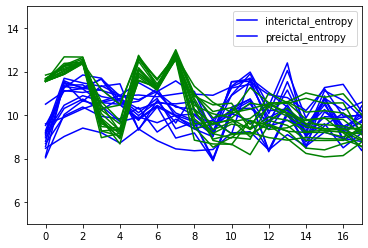

In [61]:
plt.plot(entropies_interictal, color = 'blue')
plt.plot(entropies_preictal, color = 'green')
plt.ylim(5,15)
plt.xlim(-1,17)
plt.legend(['interictal_entropy', 'preictal_entropy']);

In [64]:
entropies_interictal_2 = []
entropies_preictal_2 = []
for f in files_2:
    if f.startswith('interictal') | f.startswith('preictal'):
        data = pd.read_csv(f'{folder_path}/{dirs[1]}/train_segments_unlabelled/{f}')
        entropies = []
        for index, row in data.iterrows():
            electrode = row
            electrode_pos = electrode + abs(electrode.min())
            entropy = block_entropy(electrode_pos.to_numpy(), k=1)
            entropies.append(entropy)
        if f.startswith('interictal'):
            entropies_interictal_2.append(entropies)
        else:
            entropies_preictal_2.append(entropies)

print(len(entropies_interictal_2))
print(len(entropies_preictal_2))

42
18


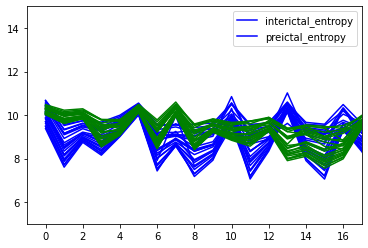

In [65]:
plt.plot(entropies_interictal_2, color = 'blue')
plt.plot(entropies_preictal_2, color = 'green')
plt.ylim(5,15)
plt.xlim(-1,17)
plt.legend(['interictal_entropy', 'preictal_entropy']);

## Entropy rate

### For one csv file

In [5]:
entropy_rate_II_1 = entropy_rate(electrode_1_II_positive.to_numpy(), k=1)

In [6]:
entropy_rate_II_1

5.457734336924455

### For all csv

In [ ]:
entropy_rates_interictal = []
entropy_rates_preictal = []
for f in files_1:
    if f.startswith('interictal') | f.startswith('preictal'):
        data = pd.read_csv(f'{folder_path}/{dirs[0]}/train_segments_unlabelled/{f}')
        entropies = []
        for index, row in data.iterrows():
            electrode = row
            electrode_pos = electrode + abs(electrode.min())
            entropy = entropy_rates(electrode_pos.to_numpy(), k=1)
            entropies.append(entropy)
        if f.startswith('interictal'):
            entropy_rates_interictal.append(entropies)
        else:
            entropy_rates_preictal.append(entropies)
            
print(len(entropy_rates_interictal))
print(len(entropy_rates_preictal))